<a href="https://colab.research.google.com/github/sonmoogu/song_classifier2/blob/main/Song_Classifier_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)

import gc
import os
import ast
import sys
import configparser
import glob
import librosa
import librosa.display
import seaborn as sns
import pandas as pd
import urllib
import urllib.request
import zipfile
import tensorflow as tf
from scipy.stats import mode

from tensorflow.keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import linalg as LA
import keras
from keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_songs(song_folder):
    song_specs = []
    idx_to_genre = []
    genre_to_idx = {}
    genres = []
    for genre in os.listdir(song_folder):
        genre_to_idx[genre] = len(genre_to_idx)
        idx_to_genre.append(genre)
        genre_folder = os.path.join(song_folder, genre)
        for song in os.listdir(genre_folder):
            if song.endswith('.wav'):
                signal, sr = librosa.load(os.path.join(genre_folder, song))
                # Calculate the melspectrogram of the audio and use log scale
                melspec = librosa.feature.melspectrogram(signal, sr=sr).T[:1280,]
                song_specs.append(melspec)
                genres.append(genre_to_idx[genre])
    return song_specs, genres, genre_to_idx, idx_to_genre

song_specs, genres, genre_to_idx, idx_to_genre = load_songs('/content/drive/MyDrive/ColabNotebooks/genres')
song_specs[0].shape

(1280, 128)

In [ ]:
MUSIC = '/content/drive/MyDrive/ColabNotebooks/genres'
music_dataset = [] # File locations for each wav file 
load_songs = []
for root, dirs, files in os.walk(MUSIC):
    for name in files:
        filename = os.path.join(root, name)
        music_dataset.append(filename)
        load_songs.append(filename.split("/")[5])

In [ ]:
print(set(load_songs))

{'genres'}


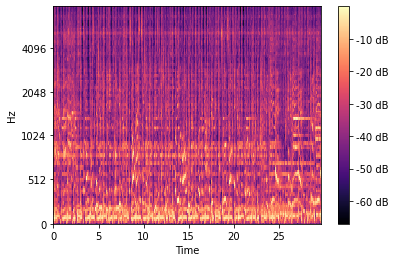

In [ ]:
librosa.display.specshow(librosa.power_to_db(song_specs[5].T,
                                              ref=np.max),
                          y_axis='mel', fmax=8000, #fmax= Used for setting the Mel frequency scales
                          x_axis='time')
plt.colorbar(format='%+.0f dB');

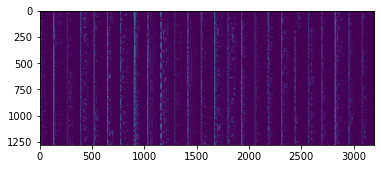

In [ ]:
def show_spectogram(show_genre):
    show_genre = genre_to_idx[show_genre]
    specs = []
    for spec, genre in zip(song_specs, genres):
        if show_genre == genre:
            specs.append(spec)
            if len(specs) == 25:
                break
    if not specs:
        return 'not found!'
    x = np.concatenate(specs, axis=1)
    x = (x - x.min()) / (x.max() - x.min())
    plt.imshow((x *20).clip(0, 1.0))

show_spectogram('disco')

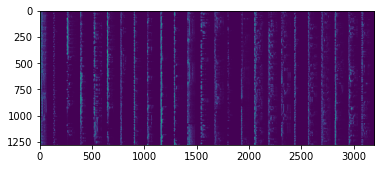

In [ ]:
show_spectogram('rock')

In [ ]:
def cnn_model(input_shape):
    inputs = Input(input_shape)
    model = Sequential([        
        
        Conv1D(32, 3, activation='relu', padding="same", kernel_initializer="he_normal",input_shape=(128,128)), 
        MaxPooling1D(pool_size=2,strides=2),
        BatchNormalization(),
        Conv1D(32, 3, activation='relu', padding="same", kernel_initializer="he_normal"),
        MaxPooling1D(pool_size=2,strides=2),
        BatchNormalization(),
        Conv1D(64, 3, activation='relu', padding="same", kernel_initializer="he_normal"),
        MaxPooling1D(pool_size=2,strides=2),
        BatchNormalization(),
        Conv1D(64, 3, activation='relu', padding="same", kernel_initializer="he_normal"),
        MaxPooling1D(pool_size=2,strides=2),
        BatchNormalization(),
        Conv1D(64, 3, activation='relu', padding="same", kernel_initializer="he_normal"),
        MaxPooling1D(pool_size=2,strides=2),
        BatchNormalization(),

        Flatten(),
        Dense(64, activation = 'relu', kernel_initializer="he_normal"),     
        Dropout(0.3),

        Dense(10, activation = 'softmax', kernel_initializer="he_normal"),
        
    ])
    
    model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['acc'])
    return model

model = cnn_model((128, 128))
model.summary()

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_187 (Conv1D)          (None, 128, 32)           12320     
_________________________________________________________________
max_pooling1d_187 (MaxPoolin (None, 64, 32)            0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 64, 32)            128       
_________________________________________________________________
conv1d_188 (Conv1D)          (None, 64, 32)            3104      
_________________________________________________________________
max_pooling1d_188 (MaxPoolin (None, 32, 32)            0         
_________________________________________________________________
batch_normalization_98 (Batc (None, 32, 32)            128       
_________________________________________________________________
conv1d_189 (Conv1D)          (None, 32, 64)          

In [ ]:
def split_10(x, y):
    s = x.shape
    s = (s[0] * 10, s[1] // 10, s[2])
    return x.reshape(s), np.repeat(y, 10, axis=0)


genres_one_hot = keras.utils.to_categorical(genres, num_classes=10)

x_train, x_test, y_train, y_test = train_test_split(
    np.array(song_specs), np.array(genres_one_hot), 
    test_size=0.1, stratify=genres)

x_test, y_test = split_10(x_test, y_test)
x_train, y_train = split_10(x_train, y_train)

x_train.shape, y_train.shape

((9000, 128, 128), (9000, 10))

In [ ]:
checkpoint_path = "tmp_checkpoint.ckpt"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)
    # Fit the model
show_process = model.fit(x_train, y_train,
      batch_size=32,
      epochs=25,
      verbose=1,
      validation_data=(x_test, y_test),
      callbacks = [checkpoint])

model.load_weights(checkpoint_path)

Epoch 1/25
282/282 [==============================] - 5s 10ms/step - loss: 2.2405 - acc: 0.2620 - val_loss: 1.4720 - val_acc: 0.4650

Epoch 00001: val_loss improved from inf to 1.47201, saving model to tmp_checkpoint.ckpt
Epoch 2/25
282/282 [==============================] - 3s 9ms/step - loss: 1.5545 - acc: 0.4511 - val_loss: 1.4487 - val_acc: 0.5360

Epoch 00002: val_loss improved from 1.47201 to 1.44870, saving model to tmp_checkpoint.ckpt
Epoch 3/25
282/282 [==============================] - 3s 9ms/step - loss: 1.3378 - acc: 0.5276 - val_loss: 1.4195 - val_acc: 0.5370

Epoch 00003: val_loss improved from 1.44870 to 1.41947, saving model to tmp_checkpoint.ckpt
Epoch 4/25
282/282 [==============================] - 2s 9ms/step - loss: 1.2061 - acc: 0.5861 - val_loss: 1.4222 - val_acc: 0.5600

Epoch 00004: val_loss did not improve from 1.41947
Epoch 5/25
282/282 [==============================] - 3s 9ms/step - loss: 1.0820 - acc: 0.6266 - val_loss: 1.3194 - val_acc: 0.5170

Epoch 00005

In [ ]:
model.save('/content/drive/MyDrive/ColabNotebooks/song_classifier4')

In [ ]:
def unsplit(values):
    chunks = np.split(values, 100)
    return np.array([np.argmax(chunk) % 10 for chunk in chunks])

true = model.predict(x_test)
predictions = unsplit(true)
truth = unsplit(y_test)
accuracy_score(predictions, truth)

0.71

In [ ]:
cm = confusion_matrix(np.argmax(true, axis=1), np.argmax(y_test, axis=1))
print(cm)

[[65  0  3  1  0  0  0  0  9  7]
 [ 5 64  0  1  0  0  0  0  5  6]
 [ 5  4 39 10  0 16  2  0  1  7]
 [ 2  5 13 74  0  6  1  0  6  2]
 [ 0  1  3  9 85 20 24  6 10 11]
 [ 2  2 32  2  8 50 15  5  4  6]
 [ 3  7  7  1  0  0 53  3  8  0]
 [ 0  8  0  1  7  5  0 86 10  0]
 [18  8  2  0  0  1  1  0 39  1]
 [ 0  1  1  1  0  2  4  0  8 60]]


In [ ]:
cm = confusion_matrix(np.argmax(true, axis=1), np.argmax(y_test, axis=1),normalize='true')
print(cm)

[[0.76470588 0.         0.03529412 0.01176471 0.         0.
  0.         0.         0.10588235 0.08235294]
 [0.0617284  0.79012346 0.         0.01234568 0.         0.
  0.         0.         0.0617284  0.07407407]
 [0.05952381 0.04761905 0.46428571 0.11904762 0.         0.19047619
  0.02380952 0.         0.01190476 0.08333333]
 [0.01834862 0.04587156 0.11926606 0.67889908 0.         0.05504587
  0.00917431 0.         0.05504587 0.01834862]
 [0.         0.00591716 0.01775148 0.05325444 0.50295858 0.1183432
  0.14201183 0.03550296 0.0591716  0.06508876]
 [0.01587302 0.01587302 0.25396825 0.01587302 0.06349206 0.3968254
  0.11904762 0.03968254 0.03174603 0.04761905]
 [0.03658537 0.08536585 0.08536585 0.01219512 0.         0.
  0.64634146 0.03658537 0.09756098 0.        ]
 [0.         0.06837607 0.         0.00854701 0.05982906 0.04273504
  0.         0.73504274 0.08547009 0.        ]
 [0.25714286 0.11428571 0.02857143 0.         0.         0.01428571
  0.01428571 0.         0.55714286 0.0

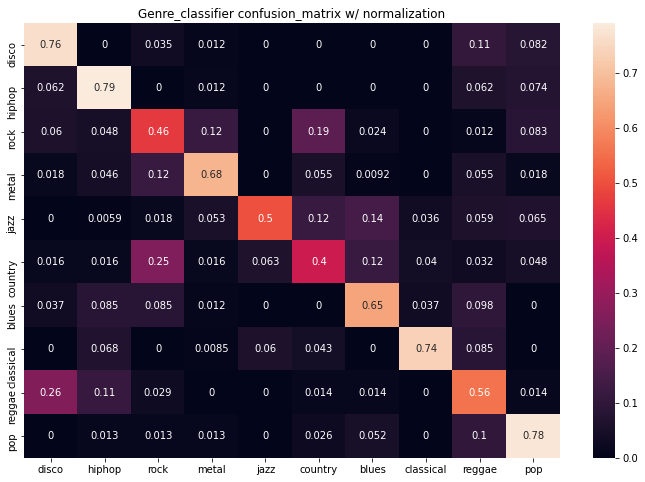

In [ ]:
df_cm=pd.DataFrame(cm,index=idx_to_genre,
                  columns=idx_to_genre)
plt.title("Genre_classifier confusion_matrix w/ normalization")
sns.heatmap(df_cm,annot=True)